In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
for i in range(3):
    s = env.reset()
    while True:
        print(s)
        a = env.action_space.sample()
        s, r, done, info = env.step(a)
        if done:
            print('End game! Reward: ', r)
            print('You win :) \n') if r >0 else print('you loose:) \n')
            break

(17, 2, False)
(18, 2, False)
End game! Reward:  0.0
you loose:) 

(16, 10, False)
End game! Reward:  -1.0
you loose:) 

(21, 9, True)
(16, 9, False)
End game! Reward:  -1
you loose:) 



In [5]:
def generate_episode_from_limit_stochastic(env):
    episodes = []
    s = env.reset()
    
    while True:
        p = [0.8, 0.2] if s[0] > 18 else [0.2, 0.8]
        a = np.random.choice(np.arange(2), p=p)
        
        next_s, r, done, info = env.step(a)
        episodes.append((s, a, r))
        
        s = next_s
        
        if done:
            break
    return episodes

In [6]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((17, 7, False), 1, -1)]
[((11, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[((18, 10, False), 1, -1)]


In [7]:
def mc_prediction_q(env, num_episodes, generate_episodes, gamma=1.0):
    return_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episodes in range(1, num_episodes+1):
        
        if i_episodes % 1000 == 0:
            print("\rEpisodes {}/{}".format(i_episodes, num_episodes), end='')
            sys.stdout.flush()
        
        ep = generate_episodes(env)
        s, a, r = zip(*ep)
        
        discnt = np.array([gamma**i for i in range(len(r) + 1)])
        
        for i, s in enumerate(s):
            return_sum[s][a[i]] += sum(r[i:]*discnt[:-(i+1)])
            N[s][a[i]] += 1.0
            Q[s][a[i]] = return_sum[s][a[i]] / N[s][a[i]]
            
    return Q 
        

Episodes 500000/500000

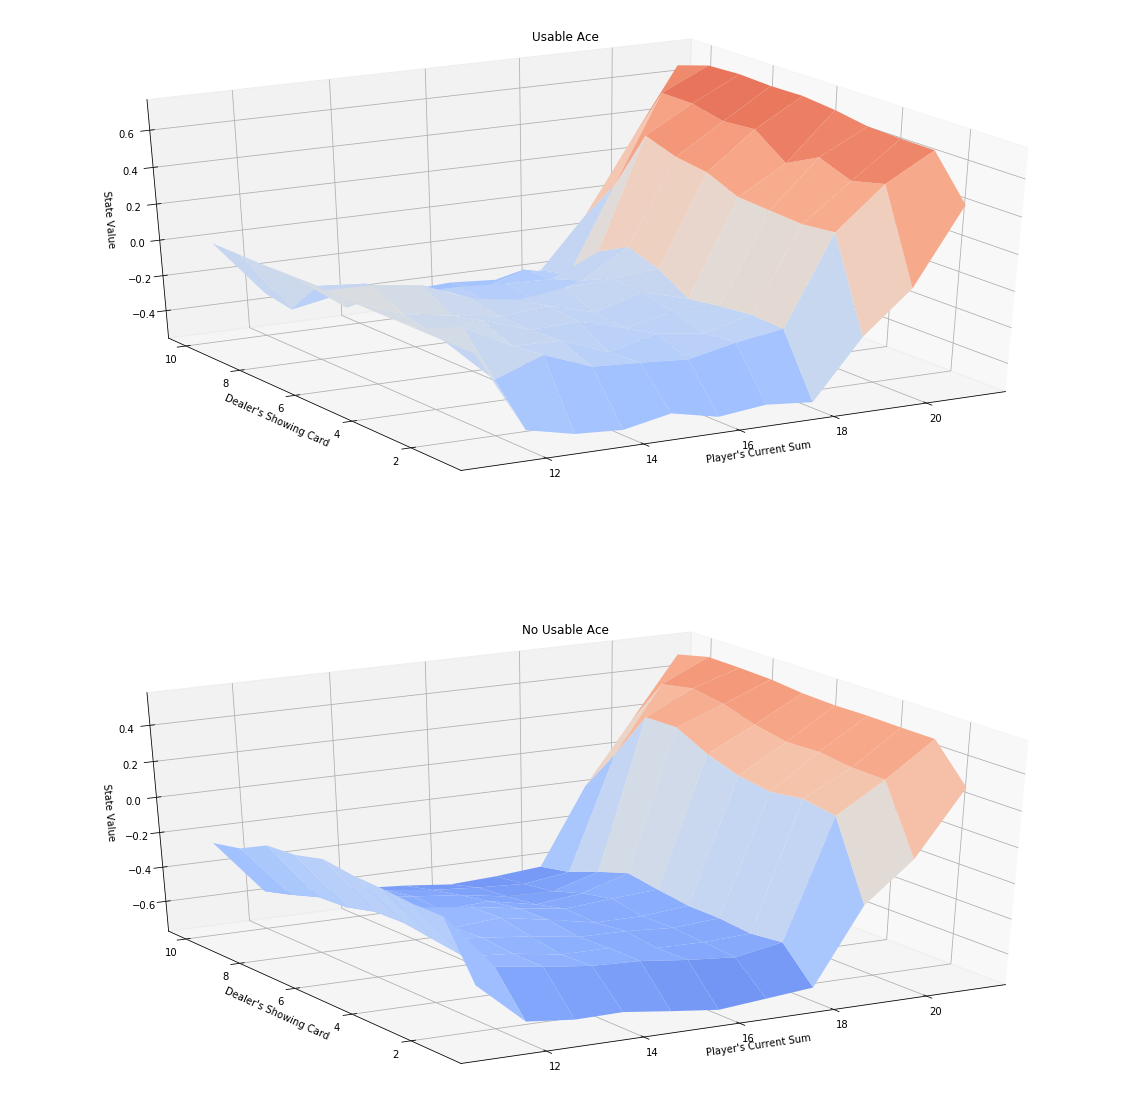

In [8]:
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)
v_to_plot = dict((k, (k[0]>18)*(np.dot([0.8, 0.2], v)) + (k[0]<=18)*(np.dot([0.2, 0.8], v)))
                for k, v in Q.items())

plot_blackjack_values(v_to_plot)

In [9]:
def get_prob(Q_s, epsilon, nA):
    
    policy_s = np.ones(nA) * epsilon /nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    
    return policy_s

def update_q(env, episode, Q, alpha, gamma):
    s, a, r = zip(*episode)
    discnt = np.array([gamma**i for i in range(len(r)+1)])
    for i, s in enumerate(s):
        old_Q = Q[s][a[i]]
        Q[s][a[i]] = old_Q + alpha *(sum(r[i:]*discnt[:-(i+1)]) - old_Q)
    return Q

    
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    s = env.reset()
    
    while True:
        a = np.random.choice(np.arange(nA), p=get_prob(Q[s], epsilon, nA)) if s in Q else env.action_space.sample()
        next_s, r, done, info = env.step(a)
        episode.append((s, a, r))
        s = next_s
        if done:
            break
    return episode

In [20]:
def mc_control(env, num_episodes, alpha, gamma=1.0, ep_start=1.0, ep_decay=.999999, ep_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    ep = ep_start
    for i in range(1, num_episodes+1):
        if i%1000 ==0:
            print("\rEpisodes {}/{}".format(i, num_episodes), end='')
            sys.stdout.flush()
        ep = max(ep*ep_decay, ep_min)
        
        episode = generate_episode_from_Q(env, Q, ep, nA)
        #print(ep, episode)
        Q = update_q(env, episode, Q, alpha, gamma)
        
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q


In [21]:
policy, Q = mc_control(env, 500000, 0.02)

Episodes 500000/500000

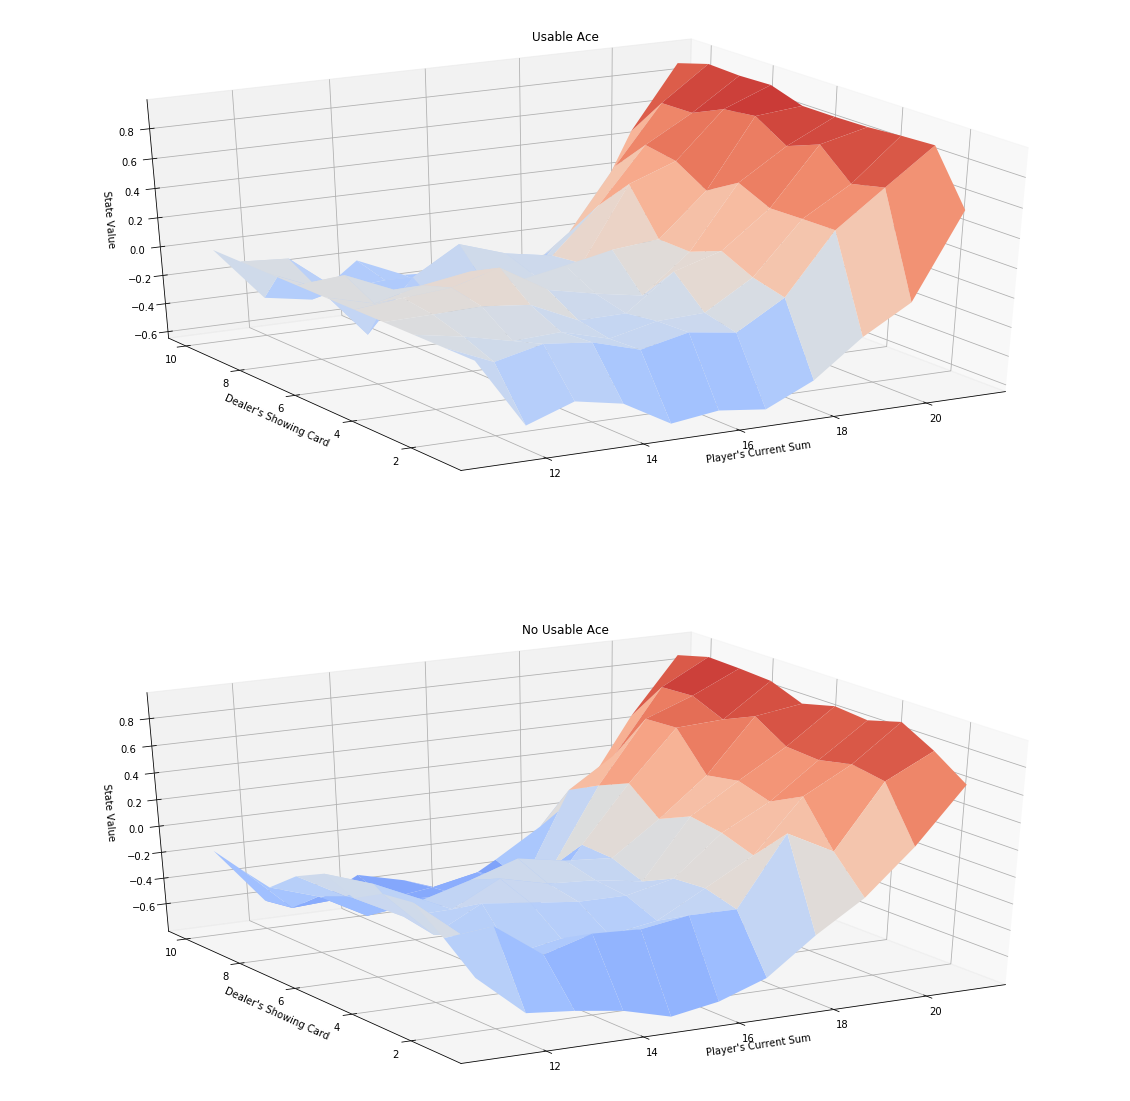

In [22]:
V = dict((k, np.max(v)) for k,v in Q.items())

plot_blackjack_values(V)

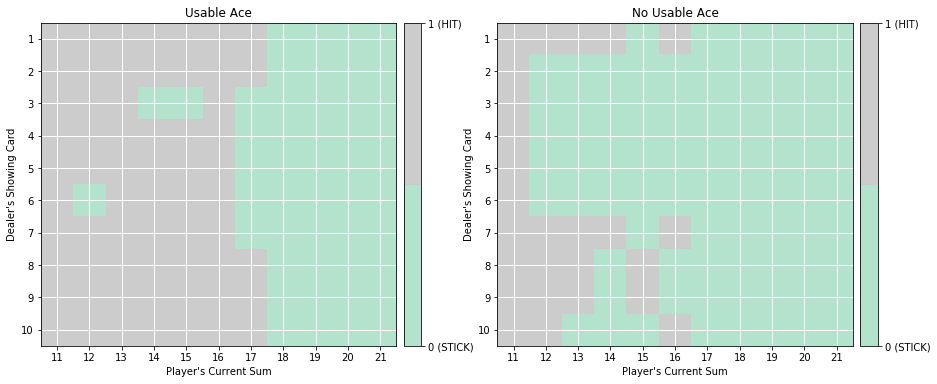

In [23]:
plot_policy(policy)